In [123]:
import pandas as pd
import numpy as np
import os
import cv2
from skimage.io import imread
from skimage.transform import resize
import matplotlib.pyplot as plt
from skimage.feature import hog
from skimage.feature import local_binary_pattern
from skimage.exposure import rescale_intensity
import cv2
import numpy as np
import random

In [124]:
df = pd.read_csv('/Users/sambeattie/Documents/Level4Project/appa-real-release/gt_avg_train.csv')
train_ds_avg = np.array(df)
print(train_ds_avg[0:5])
print(train_ds_avg.shape)
image_name_face = train_ds_avg[:,0]+'_face.jpg'
ds_real_age = train_ds_avg[:,-1]
ds_size = len(image_name_face)
print(image_name_face.shape, ds_real_age.shape)

[['000000.jpg' 36 5.0 1.14642300844222 4]
 ['000001.jpg' 63 20.0793650793651 4.09681854260339 18]
 ['000002.jpg' 38 76.8157894736842 6.13300888704189 80]
 ['000003.jpg' 38 55.6578947368421 7.86465344604949 50]
 ['000004.jpg' 15 17.6666666666667 3.45722156541651 17]]
(4113, 5)
(4113,) (4113,)


In [125]:
print(f"Number of datapoints under 18: {np.sum(ds_real_age < 25)}")
print(f"Number of datapoints 18 and over: {np.sum(ds_real_age >= 25)}")

Number of datapoints under 18: 1588
Number of datapoints 18 and over: 2525


(150, 150, 3) float64
0.0 1.0


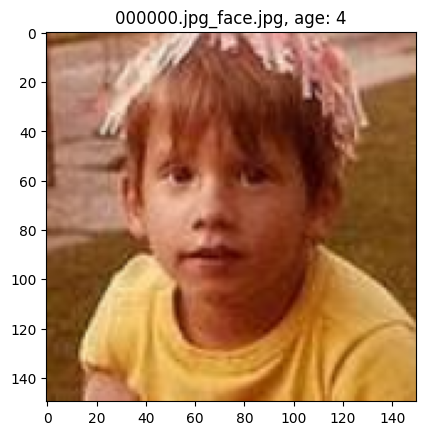

In [133]:
path = '/Users/sambeattie/Documents/Level4Project/appa-real-release/train/'
ix=0
im = resize(imread(os.path.join(path,image_name_face[ix])),(150,150))
print(im.shape, im.dtype)
print(np.min(im), np.max(im))
plt.imshow(im)
plt.title(f"{image_name_face[ix]}, age: {ds_real_age[ix]}")
plt.show()

# Load the dataset in batches

In [134]:
# Load the dataset in batches for efficiency
def random_batch_generator(image_names, real_ages, batch_size, path, target_size=(150, 150)):
    dataset_size = len(image_names)
    while True:
        batch_indices = random.sample(range(dataset_size), batch_size)  # Randomly select batch indices
        images, ages = [], []
        
        for i in batch_indices:
            # Load and resize the image
            im = resize(imread(os.path.join(path, image_names[i])), target_size)
            images.append(im)
            ages.append(real_ages[i])

        yield np.array(images), np.array(ages)  # Return a batch of images and corresponding ages

In [135]:
# Usage example:
random_gen = random_batch_generator(image_name_face, ds_real_age, batch_size=32, path=path)

# Fetch a random batch
images_batch, ages_batch = next(random_gen)

# Check the shapes
print(images_batch.shape)  # Output: (32, 150, 150, 3)
print(ages_batch.shape)    # Output: (32,)

(32, 150, 150, 3)
(32,)


(4113,)


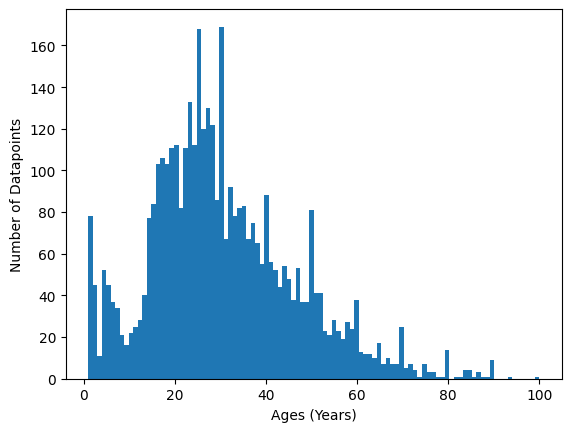

In [136]:
# Lets plot a histogram of the ages
print(ds_real_age.shape)
plt.hist(ds_real_age, bins=100)
plt.xlabel('Ages (Years)')
plt.ylabel('Number of Datapoints')
plt.show()

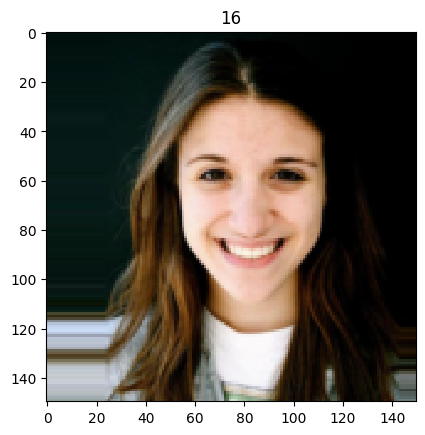

In [138]:
ix = 1
plt.imshow(images_batch[ix], interpolation='nearest')
plt.title(ages_batch[ix])
plt.show()

# Normalise image

 Shape after normalisation : (150, 150, 3) uint8
 Min / Max after normalisation : 0 255
 Shape after hrescale : (150, 150)


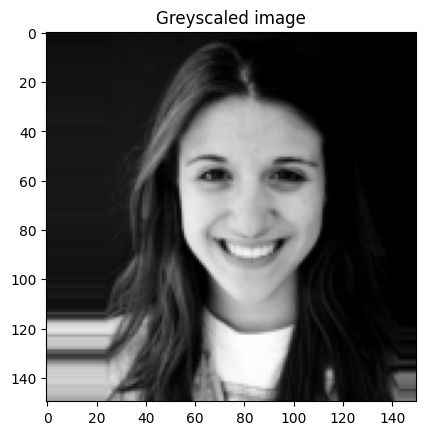

In [139]:
# Normalise to between 0-255 for use in cv2 functions
normalized_image = cv2.normalize(images_batch[ix], None, 0, 255, cv2.NORM_MINMAX)
# Change to unsigned 8bit integer so cv2 stops complaining
uint8_image = normalized_image.astype('uint8')
print(f" Shape after normalisation : {uint8_image.shape} {uint8_image.dtype}")
print(f" Min / Max after normalisation : {np.min(uint8_image)} {np.max(uint8_image)}")
grey_image = cv2.cvtColor(uint8_image, cv2.COLOR_BGR2GRAY)
print(f" Shape after hrescale : {grey_image.shape}")
plt.imshow(grey_image, cmap='grey')
plt.title('Greyscaled image')
plt.show()


Mean before equalizing histograms : 64.55653333333333
Mean after equalizing histograms  : 107.68511111111111


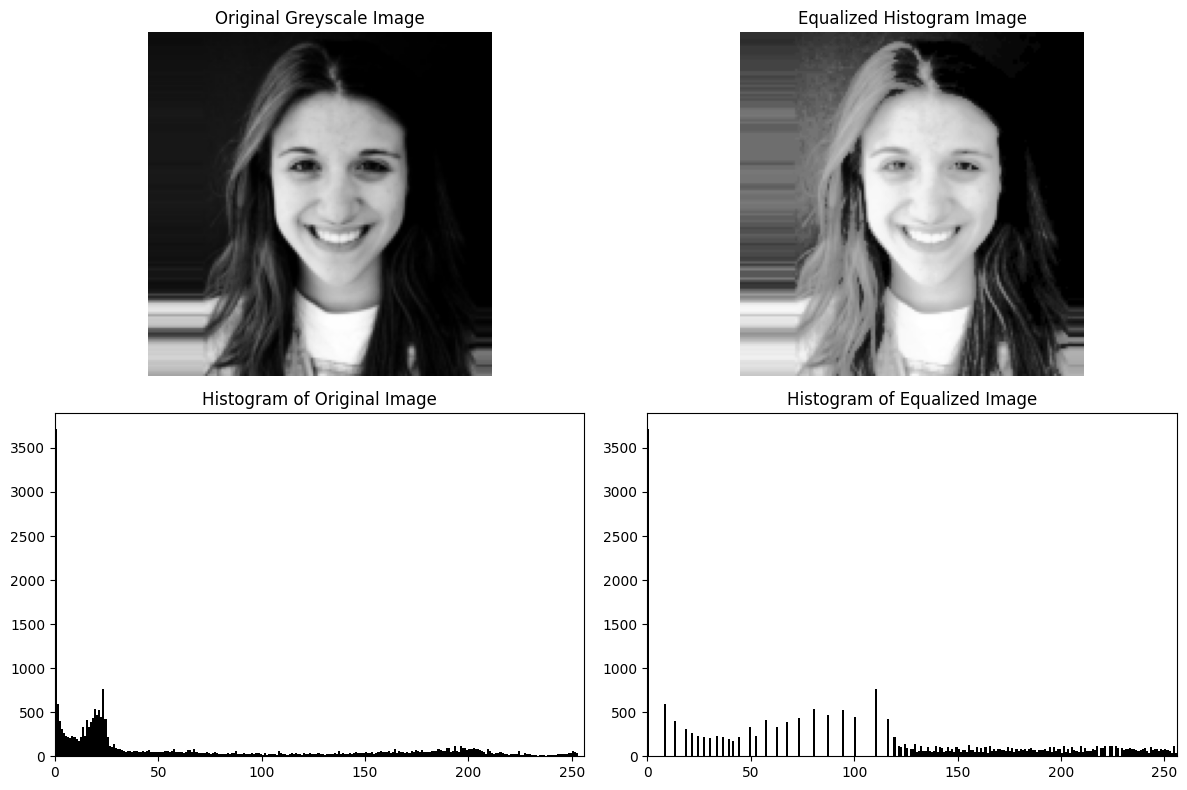

In [140]:
# Equalizing the histogram
equ = cv2.equalizeHist(grey_image)

# Display mean values
print(f"Mean before equalizing histograms : {np.mean(grey_image)}")
print(f"Mean after equalizing histograms  : {np.mean(equ)}")

# Create a figure with subplots: 2 rows and 2 columns
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# Display original greyscale image
axs[0, 0].imshow(grey_image, cmap='gray')
axs[0, 0].set_title('Original Greyscale Image')
axs[0, 0].axis('off')

# Display histogram of original greyscale image
axs[1, 0].hist(grey_image.ravel(), bins=256, range=[0, 256], color='black')
axs[1, 0].set_title('Histogram of Original Image')
axs[1, 0].set_xlim([0, 256])

# Display equalized image
axs[0, 1].imshow(equ, cmap='gray')
axs[0, 1].set_title('Equalized Histogram Image')
axs[0, 1].axis('off')

# Display histogram of equalized image
axs[1, 1].hist(equ.ravel(), bins=256, range=[0, 256], color='black')
axs[1, 1].set_title('Histogram of Equalized Image')
axs[1, 1].set_xlim([0, 256])

# Adjust layout to prevent overlapping
plt.tight_layout()

# Show the plot
plt.show()


# Feature Extraction

## Edge Detection

 edges shape : (150, 150)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


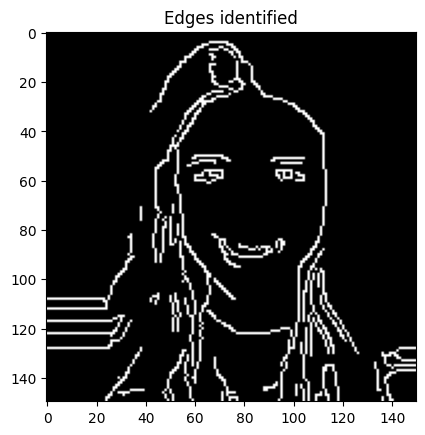

(22500,)


In [141]:
# Now we can extract the edges from the image
edge = cv2.Canny(equ, 150, 300) # The minVal and maxVal should be adjusted to suit best
print(f" edges shape : {edge.shape}")
print(edge)
plt.imshow(edge, cmap='grey')
plt.title('Edges identified')
plt.show()
flattened_edges = np.ndarray.flatten(edge)
print(flattened_edges.shape)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


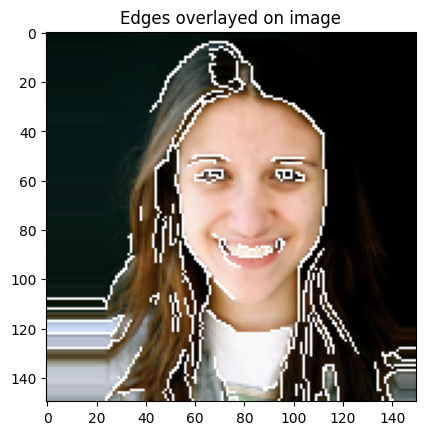

In [142]:
display_edges = np.copy(images_batch[ix])
display_edges[edge==255]=(255, 255, 255)
plt.imshow(display_edges)
plt.title('Edges overlayed on image')
plt.show()

## Local Binary Pattern

(150, 150)


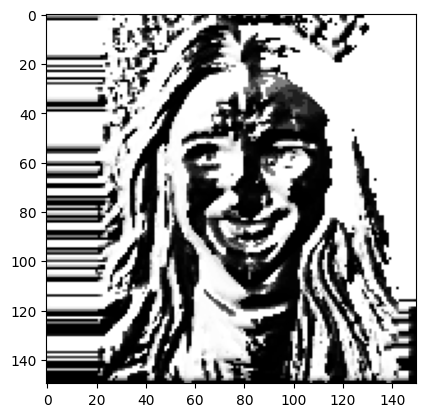

(22500,)


In [143]:
radius = 3
num_points = 9 * radius

image = equ
lbp = local_binary_pattern(grey_image, num_points, radius, method='default')
print(lbp.shape)
plt.imshow(lbp) 
plt.show()
print(np.ndarray.flatten(lbp).shape)

## Histogram of Oriented Gradients

fd shape: (2592,), HoG shape: (150, 150)


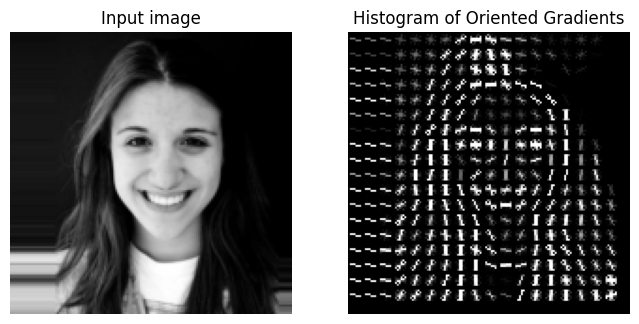

In [144]:
#creating hog features
fd, hog_image = hog(
    equ,
    orientations=8,
    pixels_per_cell=(8, 8),
    cells_per_block=(1, 1),
    visualize=True,
    feature_vector=True,
)

print(f"fd shape: {fd.shape}, HoG shape: {hog_image.shape}")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(grey_image, cmap=plt.cm.gray)
ax1.set_title('Input image')

# Rescale histogram for better display
hog_image_rescaled = rescale_intensity(hog_image, in_range=(0, 10))

ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
plt.show()